# AON and ACTION Second (Group) Level Model

Master Thesis: **Modulation of the Action Observation Network - Investigating Action, Actor and Observer Factors in an fMRI Study**

Author: Olaf Borghi olafborghi@gmail.com

## Prepare Setup

### Define fixed parameters, load libraries/modules

**Load modules**

In [2]:
# Import necessary packages and modules
%matplotlib inline
# libraries
import os
import numpy as np
import nibabel as nib
import pandas as pd
import nilearn as nl
from matplotlib import pyplot as plt
# specific modules
from nipype import Node, Workflow
from nipype.interfaces import fsl
from nilearn.glm.second_level import SecondLevelModel 
from nilearn.glm import threshold_stats_img
from nilearn import plotting, datasets, image
from nilearn.plotting import plot_design_matrix
from nilearn.image import math_img
from nilearn.maskers import MultiNiftiMasker
from pathlib import Path
from pprint import pprint
from glob import glob
from atlasreader import get_statmap_info
print(nl.__version__) # print nilearn version

/usr/local/lib/python3.8/dist-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data

0.9.2


**Set fixed parameters**

In [3]:
# fixed folders
basedir = Path("/home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION")
outputdir = Path(basedir / "derivatives")
datadir = Path(basedir / "01_data")
first_level_dir = first_level_dir = outputdir / "first_level"
action_first_level_dir = first_level_dir / "action-task"
AON_first_level_dir = first_level_dir / "AON-task"

# make folder to store mni template
if not os.path.exists(outputdir / "masks_templates"):
    os.makedirs(outputdir / "masks_templates")
masks_templates_dir = outputdir / "masks_templates"

# make folders for second level output
if not os.path.exists(outputdir / "second_level"):
    os.makedirs(outputdir / "second_level")
second_level_dir = outputdir / "second_level"

if not os.path.exists(second_level_dir / "AON-task"):
    os.makedirs(second_level_dir / "AON-task")
AON_second_level_dir = second_level_dir / "AON-task"

if not os.path.exists(second_level_dir / "action-task"):
    os.makedirs(second_level_dir / "action-task")
action_second_level_dir = second_level_dir / "action-task"

**Import functions**

I mainly used them for the first level model, but they can also be helpful to load some data for the second level model.

In [4]:
# I defined a number of functions that help me to import the data files from all subjects in a python script
import flm_helper_functions as flm_helpers
# let's look at the documentation of one of the functions
?flm_helpers.MyMRIImages

Signature: flm_helpers.MyMRIImages(paths)
Docstring:
Returns a dictionary with the functional or anatomical MRI images of each subject
loaded as a nib.img
Inputs: A list of paths to the functional/anatomical images, ordered by subject number
File:      ~/mnt/p/userdata/olafb99/shared/03_AON_ACTION/02_scripts/flm_helper_functions.py
Type:      function


## AON Second Level Model

Let's start with the second level model of the Action Observation Task.

I calculated all contrasts, as well as interactions already on the first level, so now I can just stick with one sample t-tests on the second level for the following contrasts:

1.	All action > baseline 
2.	All scrambled > baseline 
3.	All ghost > baseline 
4.	Transitive > Intransitive 
5.	Intransitive > Transitive 
6.	Human > Dog  
7.	Dog > Human 
8.	Dog Transitive > Intransitive 
9.	Dog Intransitive > Transitive 
10.	Human Transitive > Intransitive 
11.	Human Intransitive > Intransitive 
12.	Interaction Transitive/Intransitive : Human/Dog 


**Load the anatomical data**

In [5]:
# store the paths of the warped anatomical images of all subjects in a list and load them using the function
anat_paths = sorted(glob(f"{outputdir}/*/AON_run-01.feat/reg/highres2standard.nii.gz"))
anat_dict = flm_helpers.MyMRIImages(anat_paths)

# load the MNI template
template = datasets.load_mni152_template(resolution=1)

# store the MNI template also locally
mni_image_path = f"{masks_templates_dir}/mni_template_1mm.nii.gz"
template.to_filename(mni_image_path)

**Load the contrast maps of interest**

In [66]:
## Action observation contrast 


## contrasts to baseline

# all action observation - baseline
cmaps_aon = sorted(
    glob(f"{AON_first_level_dir}/main-baseline/*.nii.gz",
         recursive=True)
)

# human transitive - baseline
cmaps_transitive_baseline_human = sorted(
    glob(f"{AON_first_level_dir}/human_transitive-baseline/*.nii.gz",
         recursive=True)
)

# human intransitive - baseline
cmaps_intransitive_baseline_human = sorted(
    glob(f"{AON_first_level_dir}/human_intransitive-baseline/*.nii.gz",
         recursive=True)
)

# dog transitive - baseline
cmaps_transitive_baseline_dog = sorted(
    glob(f"{AON_first_level_dir}/dog_transitive-baseline/*.nii.gz",
         recursive=True)
)

# dog intransitive - baseline
cmaps_intransitive_baseline_dog = sorted(
    glob(f"{AON_first_level_dir}/dog_intransitive-baseline/*.nii.gz",
         recursive=True)
)

## Transitive - intransitive contrast

# dog and human actor
cmaps_transitive_intransitive = sorted(
    glob(f"{AON_first_level_dir}/transitive-intransitive/*.nii.gz",
         recursive=True)
)

# human actor
cmaps_transitive_intransitive_human = sorted(
    glob(f"{AON_first_level_dir}/human_transitive-intransitive/*.nii.gz",
         recursive=True)
)

# dog actor
cmaps_transitive_intransitive_dog = sorted(
    glob(f"{AON_first_level_dir}/dog_transitive-intransitive/*.nii.gz",
         recursive=True)
)


## Intransitive - transitive contrast

# dog and human actor
cmaps_intransitive_transitive = sorted(
    glob(f"{AON_first_level_dir}/intransitive-transitive/*.nii.gz",
         recursive=True)
)

# human actor
cmaps_intransitive_transitive_human = sorted(
    glob(f"{AON_first_level_dir}/human_intransitive-transitive/*.nii.gz",
         recursive=True)
)

# dog actor
cmaps_intransitive_transitive_dog = sorted(
    glob(f"{AON_first_level_dir}/dog_intransitive-transitive/*.nii.gz",
         recursive=True)
)

## Human - dog contrast

cmaps_human_dog = sorted(
    glob(f"{AON_first_level_dir}/human-dog/*.nii.gz",
         recursive=True)
)

## Dog - human contrast

cmaps_dog_human = sorted(
    glob(f"{AON_first_level_dir}/dog-human/*.nii.gz",
         recursive=True)
)

## Interaction contrasts

cmaps_interaction = sorted(
    glob(f"{AON_first_level_dir}/interaction_action-agent/*.nii.gz",
         recursive=True)
)

cmaps_interaction_reversed = sorted(
    glob(f"{AON_first_level_dir}/reversed_interaction_action-agent/*.nii.gz",
         recursive=True)
)

## Whole brain control contrasts

cmaps_ghost = sorted(
    glob(f"{AON_first_level_dir}/ghost-baseline/*.nii.gz",
         recursive=True)
)

cmaps_scrambled = sorted(
    glob(f"{AON_first_level_dir}/scrambled-baseline/*.nii.gz",
         recursive=True)
)

cmaps_action_ghost = sorted(
    glob(f"{AON_first_level_dir}/action-ghost/*.nii.gz",
         recursive=True)
)

cmaps_action_scrambled = sorted(
    glob(f"{AON_first_level_dir}/action-scrambled/*.nii.gz",
         recursive=True)
)

**Create subject list**

In [9]:
# create a list with all subject ids for indexing
subject_list = [f"sub-{i:02d}" for i in range(1, 41)]
print(subject_list)

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37', 'sub-38', 'sub-39', 'sub-40']


#### Create function to do a one-sample t-Test on the second level

I start by creating a function that takes off some work from my shoulders. 

I only need to provide
- the subject list (created above: subject_list)
- a list of cmaps (loaded above: cmaps)
- and an output path with name for the generated contrast and mask images

In [27]:
def MySecondLevelTTest(subject_list, cmaps, contrast_path, mask_path):
    ''' 
    Takes a list of subject names (i.e., sub-01 to sub-10), a single contrast map per subject, 
    and a output directory and name for the computed z-contrast map based on a one sample t-test
    and a output directory and mae for the default brain mask based on the contrast images as input. 
    
    Stores the z-contrast image in the contrast_path (e.g., f"{AON_second_level_dir}/AON-baseline_z_map.nii.gz")
    and the mask image in the mask_path, so that they can be used for subsequent correction for multiple comparisons. 
    '''
    n = len(subject_list)
    # create design matrix
    print("Creating design matrix")
    design = pd.DataFrame([1] * n,
                          columns = ["intercept"],
                          index = subject_list)
    # fit second level object
    print("Fitting second level model")
    second_level = SecondLevelModel(n_jobs=2, verbose=1, minimize_memory=False)
    second_level = second_level.fit(cmaps, design_matrix = design)
    # compute contrast
    print("Computing contrast")
    contrast = second_level.compute_contrast(second_level_contrast = "intercept",
                                             output_type = "z_score")
    # create default mask
    print("Creating default mask based on cmaps")
    default_masker = MultiNiftiMasker(mask_img=None, smoothing_fwhm=None, standardize=False, standardize_confounds=True, 
                                      detrend=False, high_variance_confounds=False, low_pass=None, high_pass=None, 
                                      t_r=None, target_affine=None, target_shape=None,  mask_strategy='background', 
                                      mask_args=None, dtype=None, memory_level=0, n_jobs=1, verbose=0)
    brain_mask_fit = default_masker.fit(cmaps, y=None)
    brain_mask = brain_mask_fit.mask_img_
    # store the mask and the contrast map
    print("Storing the z-contrast map in directory:", contrast_path, "and default brain mask in", mask_path)
    contrast.to_filename(contrast_path)
    brain_mask.to_filename(mask_path)
    print("Done")

### 1. All action observation > baseline

In [28]:
# define paths
aon_avg_image_path = f"{AON_second_level_dir}/AON-baseline_z_map.nii.gz"
AON_brain_mask_path = f"{masks_templates_dir}/AON_brain_mask.nii.gz"

# use the function
MySecondLevelTTest(subject_list, cmaps_aon, aon_avg_image_path, AON_brain_mask_path)

Creating design matrix
Fitting second level model


Fitting second level model. Take a deep breath
Computation of second level model done in 0 seconds


Computing contrast
Creating default mask based on cmaps
Storing the z-contrast map in directory: /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/second_level/AON-task/AON-baseline_z_map.nii.gz and default brain mask in /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/masks_templates/AON_brain_mask.nii.gz
Done


**However, we still have to correct the image for multiple comparisons. I use FSL cluster to threshold the stats image with alpha = .001 (uncorrected) on a voxel level and correct for multiple comparisons on a cluster level (alpha = .05) using Gaussian Random Field (GRF) theory!**

For documentation, see
- https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#smoothestimate
- https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Cluster

and for an implementation
- https://github.com/medianeuroscience/nipype_repro/blob/master/notebooks/nipype_fsl_third_level.ipynb

In [30]:
# use the mask to run FSL smoothest
aon_smooth = fsl.SmoothEstimate(mask_file=AON_brain_mask_path, zstat_file=aon_avg_image_path)
aon_smooth.run()

230417-18:50:19,684 nipype.interface INFO:
	 stdout 2023-04-17T18:50:19.683910:DLH 0.0133002
230417-18:50:19,686 nipype.interface INFO:
	 stdout 2023-04-17T18:50:19.683910:VOLUME 239547
230417-18:50:19,687 nipype.interface INFO:
	 stdout 2023-04-17T18:50:19.683910:RESELS 347.113


Use the inputs from fsl.SmoothEstimate for our GRF correction

In [31]:
# create fsl cluster object with the inputs from above
aon_cluster = fsl.Cluster(in_file = aon_avg_image_path,
                          dlh = 0.0133002,
                          volume = 239547,
                          threshold = 3.1, # uncorrected threshold in z-scale of alpha = .001
                          pthreshold = 0.05, # cluster level threshold of alpha = .05
                          out_threshold_file =True,
                          out_index_file = True,
                          out_localmax_txt_file = True,
                          minclustersize = True)

In [32]:
# change the working directory to the directory in which I want to have my output
os.chdir(AON_second_level_dir)
# run fsl cluster to create the thresholded map
aon_cluster.run()

230417-18:51:08,733 nipype.interface INFO:
	 stdout 2023-04-17T18:51:08.733100:Minimum cluster size under p-threshold = 314
230417-18:51:08,735 nipype.interface INFO:
	 stdout 2023-04-17T18:51:08.735381:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
230417-18:51:08,736 nipype.interface INFO:
	 stdout 2023-04-17T18:51:08.735381:6	29470	2.77e-42	41.6	10	69	24	39	40.2	26.6	38.9
230417-18:51:08,737 nipype.interface INFO:
	 stdout 2023-04-17T18:51:08.735381:5	4266	1.23e-11	10.9	6.99	22	68	48	21.2	70.5	50.3
230417-18:51:08,738 nipype.interface INFO:
	 stdout 2023-04-17T18:51:08.735381:4	3504	3.34e-10	9.48	6.65	62	34	66	66.2	42.9	59.2
230417-18:51:08,738 nipype.interface INFO:
	 stdout 2023-04-17T18:51:08.735381:3	2181	1.79e-07	6.75	10.1	35	47	37	31.6	56.7	28.5
230417-18:51:08,739 nipype.interface INFO:
	 stdout 2023-04-17T18:51:08.735381:2	1997	5.36e-07	6.27	6.24	71	65	57	68.1	64.9	55.7
230417-18:51:08,740 nipype.interface INFO:
	

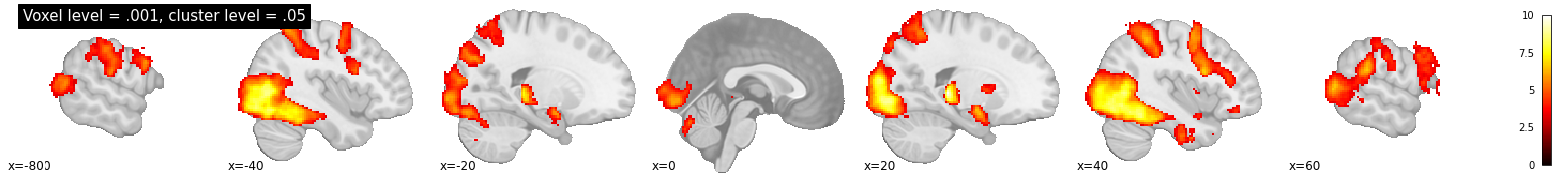

In [33]:
aon_thresholded_map = AON_second_level_dir / "AON-baseline_z_map_threshold.nii.gz"

plotting.plot_stat_map(aon_thresholded_map, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Voxel level = .001, cluster level = .05", bg_img = template, black_bg=False)

In [65]:
# get info on anatomical regions of cluster peaks
cluster_info, peak_info = get_statmap_info(aon_thresholded_map,
                                           cluster_extent = 1)
peak_info.head(5)

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,-48.0,-78.0,6.0,10.017009,235664.0,Occipital_Mid_L,ctx-lh-lateraloccipital,77.0% Left_Lateral_Occipital_Cortex_inferior_d...
1,2.0,46.0,10.0,24.0,6.985251,34048.0,Frontal_Inf_Oper_R,Unknown,32.0% Right_Inferior_Frontal_Gyrus_pars_opercu...
2,3.0,-34.0,-58.0,60.0,6.646280,28024.0,Parietal_Sup_L,ctx-lh-superiorparietal,35.0% Left_Superior_Parietal_Lobule; 27.0% Lef...
3,4.0,20.0,-32.0,2.0,10.059263,17296.0,Thalamus_R,Right-Thalamus-Proper,91.0% Right_Thalamus
4,5.0,-52.0,4.0,42.0,6.236378,15976.0,Precentral_L,ctx-lh-precentral,56.0% Left_Precentral_Gyrus; 21.0% Left_Middle...


### 2. All scrambled > baseline 

In [81]:
# define paths
scrambled_image_path = f"{AON_second_level_dir}/scrambled-baseline_z_map.nii.gz"
scrambled_brain_mask_path = f"{masks_templates_dir}/scrambled-baseline_mask.nii.gz"

# use the function
MySecondLevelTTest(subject_list, cmaps_scrambled, scrambled_image_path, scrambled_brain_mask_path)

Creating design matrix
Fitting second level model


Fitting second level model. Take a deep breath
Computation of second level model done in 0 seconds


Computing contrast
Creating default mask based on cmaps
Storing the z-contrast map in directory: /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/second_level/AON-task/scrambled-baseline_z_map.nii.gz and default brain mask in /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/masks_templates/scrambled-baseline_mask.nii.gz
Done


In [82]:
# use the mask to run FSL smoothest
scrambled_smooth = fsl.SmoothEstimate(mask_file=scrambled_brain_mask_path, zstat_file=scrambled_image_path)
scrambled_smooth.run()

230417-19:59:44,673 nipype.interface INFO:
	 stdout 2023-04-17T19:59:44.673292:DLH 0.0168079
230417-19:59:44,675 nipype.interface INFO:
	 stdout 2023-04-17T19:59:44.673292:VOLUME 239547
230417-19:59:44,676 nipype.interface INFO:
	 stdout 2023-04-17T19:59:44.673292:RESELS 274.673


Use the inputs from fsl.SmoothEstimate for our GRF correction

In [83]:
# create fsl cluster object with the inputs from above
scrambled_cluster = fsl.Cluster(in_file = scrambled_image_path,
                                dlh = 0.0168079,
                                volume = 239547,
                                threshold = 3.1, # uncorrected threshold in z-scale of alpha = .001
                                pthreshold = 0.05, # cluster level threshold of alpha = .05
                                out_threshold_file =True,
                                out_index_file = True,
                                out_localmax_txt_file = True,
                                minclustersize = True)

In [84]:
# change the working directory to the directory in which I want to have my output
os.chdir(AON_second_level_dir)
# run fsl cluster to create the thresholded map
scrambled_cluster.run()

230417-20:00:30,463 nipype.interface INFO:
	 stdout 2023-04-17T20:00:30.463539:Minimum cluster size under p-threshold = 267
230417-20:00:30,465 nipype.interface INFO:
	 stdout 2023-04-17T20:00:30.463539:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
230417-20:00:30,466 nipype.interface INFO:
	 stdout 2023-04-17T20:00:30.463539:3	15867	1.33e-32	31.9	10.4	51	18	32	42.9	21.3	37
230417-20:00:30,467 nipype.interface INFO:
	 stdout 2023-04-17T20:00:30.463539:2	362	0.0166	1.78	4.62	19	66	55	20.2	67.4	50.2
230417-20:00:30,468 nipype.interface INFO:
	 stdout 2023-04-17T20:00:30.468495:1	273	0.0462	1.34	5.51	13	46	48	13.4	46	48.1


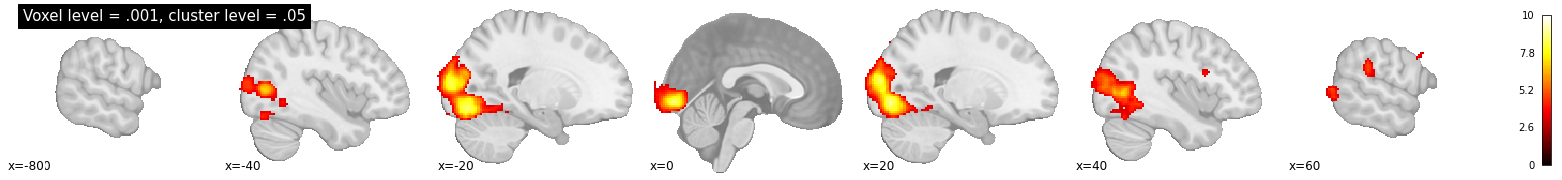

In [89]:
scrambled_thresholded_map = AON_second_level_dir / "scrambled-baseline_z_map_threshold.nii.gz"

plotting.plot_stat_map(scrambled_thresholded_map, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Voxel level = .001, cluster level = .05", bg_img = template, black_bg=False)

In [87]:
# get info on anatomical regions of cluster peaks
cluster_info, peak_info = get_statmap_info(scrambled_thresholded_map,
                                           cluster_extent = 1)
peak_info.head(5)

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,-12.0,-90.0,-8.0,10.422804,126688.0,Lingual_L,Left-Cerebral-White-Matter,19.0% Left_Lingual_Gyrus; 17.0% Left_Occipital...
1,2.0,52.0,6.0,38.0,4.615279,2896.0,Precentral_R,Unknown,58.0% Right_Precentral_Gyrus; 17.0% Right_Midd...
2,3.0,64.0,-34.0,24.0,5.506224,2184.0,SupraMarginal_R,Right-Cerebral-White-Matter,22.0% Right_Supramarginal_Gyrus_posterior_divi...
3,4.0,26.0,-86.0,52.0,3.547191,184.0,no_label,Unknown,0% no_label
4,5.0,-22.0,-100.0,-18.0,3.605418,40.0,no_label,Unknown,22.0% Left_Occipital_Pole


### 3. Ghost > baseline 

In [98]:
# define paths
ghost_image_path = f"{AON_second_level_dir}/ghost-baseline_z_map.nii.gz"
ghost_brain_mask_path = f"{masks_templates_dir}/ghost-baseline_mask.nii.gz"

# use the function
MySecondLevelTTest(subject_list, cmaps_ghost, ghost_image_path, ghost_brain_mask_path)

Creating design matrix
Fitting second level model


Fitting second level model. Take a deep breath
Computation of second level model done in 0 seconds


Computing contrast
Creating default mask based on cmaps
Storing the z-contrast map in directory: /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/second_level/AON-task/ghost-baseline_z_map.nii.gz and default brain mask in /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/masks_templates/ghost-baseline_mask.nii.gz
Done


In [99]:
# use the mask to run FSL smoothest
ghost_smooth = fsl.SmoothEstimate(mask_file=ghost_brain_mask_path, zstat_file=ghost_image_path)
ghost_smooth.run()

230418-12:27:21,571 nipype.interface INFO:
	 stdout 2023-04-18T12:27:21.570933:DLH 0.0172936
230418-12:27:21,573 nipype.interface INFO:
	 stdout 2023-04-18T12:27:21.570933:VOLUME 239547
230418-12:27:21,574 nipype.interface INFO:
	 stdout 2023-04-18T12:27:21.570933:RESELS 266.958


Use the inputs from fsl.SmoothEstimate for our GRF correction

In [100]:
# create fsl cluster object with the inputs from above
ghost_cluster = fsl.Cluster(in_file = ghost_image_path,
                            dlh = 0.0172936,
                            volume = 239547,
                            threshold = 3.1, # uncorrected threshold in z-scale of alpha = .001
                            pthreshold = 0.05, # cluster level threshold of alpha = .05
                            out_threshold_file =True,
                            out_index_file = True,
                            out_localmax_txt_file = True,
                            minclustersize = True)

In [101]:
# change the working directory to the directory in which I want to have my output
os.chdir(AON_second_level_dir)
# run fsl cluster to create the thresholded map
ghost_cluster.run()

230418-12:27:25,153 nipype.interface INFO:
	 stdout 2023-04-18T12:27:25.152917:Minimum cluster size under p-threshold = 262
230418-12:27:25,154 nipype.interface INFO:
	 stdout 2023-04-18T12:27:25.154848:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
230418-12:27:25,155 nipype.interface INFO:
	 stdout 2023-04-18T12:27:25.154848:4	22656	3.69e-42	41.4	7.97	68	26	39	38	31.1	41.9
230418-12:27:25,156 nipype.interface INFO:
	 stdout 2023-04-18T12:27:25.154848:3	4544	2.37e-14	13.6	7.19	23	67	49	21.9	70	50.7
230418-12:27:25,157 nipype.interface INFO:
	 stdout 2023-04-18T12:27:25.154848:2	4182	1.43e-13	12.8	6.33	69	67	54	66.5	69.2	51.7
230418-12:27:25,158 nipype.interface INFO:
	 stdout 2023-04-18T12:27:25.154848:1	3796	1.03e-12	12	7.39	60	40	59	64.4	37.6	60.2


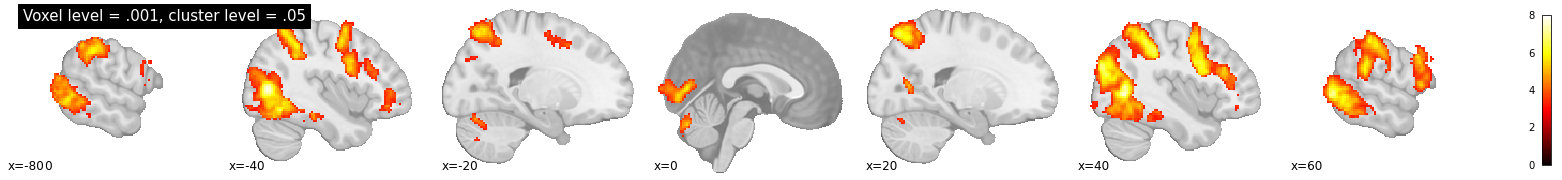

In [102]:
ghost_thresholded_map = AON_second_level_dir / "ghost-baseline_z_map_threshold.nii.gz"

plotting.plot_stat_map(ghost_thresholded_map, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Voxel level = .001, cluster level = .05", bg_img = template, black_bg=False)

In [103]:
# get info on anatomical regions of cluster peaks
cluster_info, peak_info = get_statmap_info(ghost_thresholded_map,
                                           cluster_extent = 1)
peak_info.head(5)

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,42.0,-64.0,8.0,7.781974,101568.0,Temporal_Mid_R,ctx-rh-lateraloccipital,42.0% Right_Lateral_Occipital_Cortex_inferior_...
1,2.0,-46.0,-74.0,6.0,7.970373,78160.0,Occipital_Mid_L,ctx-lh-lateraloccipital,64.0% Left_Lateral_Occipital_Cortex_inferior_d...
2,3.0,44.0,8.0,26.0,7.192701,36320.0,Frontal_Inf_Oper_R,Unknown,37.0% Right_Precentral_Gyrus; 21.0% Right_Infe...
3,4.0,-48.0,8.0,36.0,6.326347,33376.0,Precentral_L,Unknown,37.0% Left_Middle_Frontal_Gyrus; 30.0% Left_Pr...
4,5.0,-30.0,-46.0,46.0,7.392073,30368.0,Parietal_Inf_L,Left-Cerebral-White-Matter,44.0% Left_Superior_Parietal_Lobule; 6.0% Left...


### 4. Transitive > intransitive

In [104]:
# define paths
transitive_intransitive_image_path = f"{AON_second_level_dir}/transitive-intransitive_z_map.nii.gz"
transitive_intransitive_brain_mask_path = f"{masks_templates_dir}/transitive-intransitive_mask.nii.gz"

# use the function
MySecondLevelTTest(subject_list, cmaps_transitive_intransitive, transitive_intransitive_image_path, transitive_intransitive_brain_mask_path)

Creating design matrix
Fitting second level model


Fitting second level model. Take a deep breath
Computation of second level model done in 0 seconds


Computing contrast
Creating default mask based on cmaps
Storing the z-contrast map in directory: /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/second_level/AON-task/transitive-intransitive_z_map.nii.gz and default brain mask in /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/masks_templates/transitive-intransitive_mask.nii.gz
Done


In [105]:
# use the mask to run FSL smoothest
transitive_intransitive_smooth = fsl.SmoothEstimate(mask_file=transitive_intransitive_brain_mask_path, zstat_file=transitive_intransitive_image_path)
transitive_intransitive_smooth.run()

230422-12:37:01,520 nipype.interface INFO:
	 stdout 2023-04-22T12:37:01.520238:DLH 0.0821167
230422-12:37:01,522 nipype.interface INFO:
	 stdout 2023-04-22T12:37:01.520238:VOLUME 239547
230422-12:37:01,523 nipype.interface INFO:
	 stdout 2023-04-22T12:37:01.520238:RESELS 56.2207


Use the inputs from fsl.SmoothEstimate for our GRF correction

In [106]:
# create fsl cluster object with the inputs from above
transitive_intransitive_cluster = fsl.Cluster(in_file = transitive_intransitive_image_path,
                            dlh = 0.0821167,
                            volume = 239547,
                            threshold = 3.1, # uncorrected threshold in z-scale of alpha = .001
                            pthreshold = 0.05, # cluster level threshold of alpha = .05
                            out_threshold_file =True,
                            out_index_file = True,
                            out_localmax_txt_file = True,
                            minclustersize = True)

In [107]:
# change the working directory to the directory in which I want to have my output
os.chdir(AON_second_level_dir)
# run fsl cluster to create the thresholded map
transitive_intransitive_cluster.run()

230422-12:37:42,581 nipype.interface INFO:
	 stdout 2023-04-22T12:37:42.580985:Minimum cluster size under p-threshold = 83
230422-12:37:42,584 nipype.interface INFO:
	 stdout 2023-04-22T12:37:42.584105:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
230422-12:37:42,585 nipype.interface INFO:
	 stdout 2023-04-22T12:37:42.584105:3	1039	1.72e-14	13.8	5.29	38	24	31	34.1	29.6	30.5
230422-12:37:42,586 nipype.interface INFO:
	 stdout 2023-04-22T12:37:42.584105:2	859	1.14e-12	11.9	5.87	58	32	28	58.9	31.9	29.4
230422-12:37:42,587 nipype.interface INFO:
	 stdout 2023-04-22T12:37:42.584105:1	326	2.98e-06	5.53	4.81	47	17	48	47.6	16.3	45.9


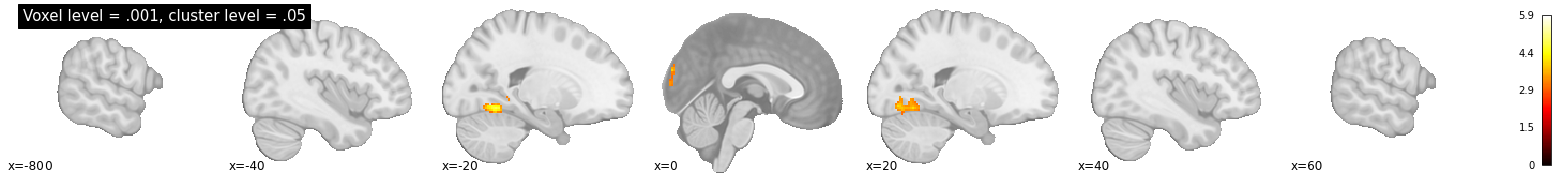

In [108]:
transitive_intransitive_thresholded_map = AON_second_level_dir / "transitive-intransitive_z_map_threshold.nii.gz"

plotting.plot_stat_map(transitive_intransitive_thresholded_map, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Voxel level = .001, cluster level = .05", bg_img = template, black_bg=False)

In [109]:
# get info on anatomical regions of cluster peaks
cluster_info, peak_info = get_statmap_info(transitive_intransitive_thresholded_map,
                                           cluster_extent = 1)
peak_info.head(5)

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,14.0,-78.0,-10.0,5.292389,7992.0,Lingual_R,ctx-rh-lingual,38.0% Right_Lingual_Gyrus; 22.0% Right_Occipit...
1,2.0,-26.0,-62.0,-16.0,5.865399,6720.0,Fusiform_L,Unknown,44.0% Left_Temporal_Occipital_Fusiform_Cortex;...
2,3.0,-4.0,-92.0,24.0,4.812029,2568.0,Cuneus_L,ctx-lh-superiorparietal,61.0% Left_Occipital_Pole; 14.0% Left_Cuneal_C...
3,4.0,32.0,-30.0,-22.0,3.851235,312.0,Fusiform_R,ctx-rh-fusiform,62.0% Right_Temporal_Fusiform_Cortex_posterior...
4,5.0,-32.0,-38.0,-24.0,3.564205,104.0,Fusiform_L,Unknown,85.0% Left_Temporal_Fusiform_Cortex_posterior_...


### 5. Intransitive > transitive

In [111]:
# define paths
intransitive_transitive_image_path = f"{AON_second_level_dir}/intransitive-transitive_z_map.nii.gz"
intransitive_transitive_brain_mask_path = f"{masks_templates_dir}/intransitive-transitive_mask.nii.gz"

# use the function
MySecondLevelTTest(subject_list, cmaps_intransitive_transitive, intransitive_transitive_image_path, intransitive_transitive_brain_mask_path)

Creating design matrix
Fitting second level model


Fitting second level model. Take a deep breath
Computation of second level model done in 0 seconds


Computing contrast
Creating default mask based on cmaps
Storing the z-contrast map in directory: /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/second_level/AON-task/intransitive-transitive_z_map.nii.gz and default brain mask in /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/masks_templates/intransitive-transitive_mask.nii.gz
Done


In [112]:
# use the mask to run FSL smoothest
intransitive_transitive_smooth = fsl.SmoothEstimate(mask_file=intransitive_transitive_brain_mask_path, zstat_file=intransitive_transitive_image_path)
intransitive_transitive_smooth.run()

230422-12:46:03,370 nipype.interface INFO:
	 stdout 2023-04-22T12:46:03.370520:DLH 0.0821167
230422-12:46:03,373 nipype.interface INFO:
	 stdout 2023-04-22T12:46:03.370520:VOLUME 239547
230422-12:46:03,374 nipype.interface INFO:
	 stdout 2023-04-22T12:46:03.370520:RESELS 56.2207


Use the inputs from fsl.SmoothEstimate for our GRF correction

In [113]:
# create fsl cluster object with the inputs from above
intransitive_transitive_cluster = fsl.Cluster(in_file = intransitive_transitive_image_path,
                            dlh = 0.0821167,
                            volume = 239547,
                            threshold = 3.1, # uncorrected threshold in z-scale of alpha = .001
                            pthreshold = 0.05, # cluster level threshold of alpha = .05
                            out_threshold_file =True,
                            out_index_file = True,
                            out_localmax_txt_file = True,
                            minclustersize = True)

In [114]:
# change the working directory to the directory in which I want to have my output
os.chdir(AON_second_level_dir)
# run fsl cluster to create the thresholded map
intransitive_transitive_cluster.run()

230422-12:46:31,123 nipype.interface INFO:
	 stdout 2023-04-22T12:46:31.123303:Minimum cluster size under p-threshold = 83
230422-12:46:31,125 nipype.interface INFO:
	 stdout 2023-04-22T12:46:31.125048:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)


/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


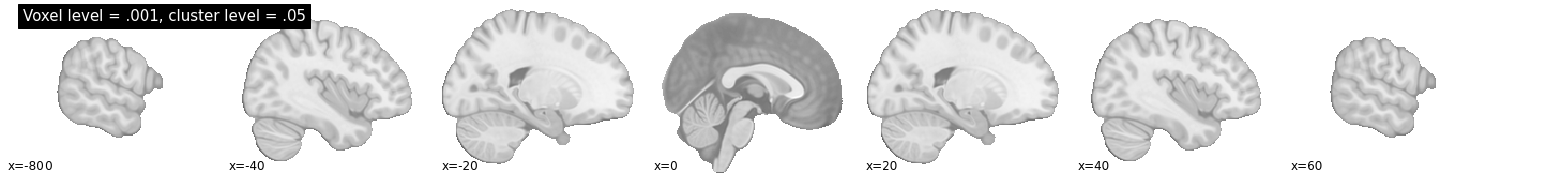

In [115]:
intransitive_transitive_thresholded_map = AON_second_level_dir / "intransitive-transitive_z_map_threshold.nii.gz"

plotting.plot_stat_map(intransitive_transitive_thresholded_map, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Voxel level = .001, cluster level = .05", bg_img = template, black_bg=False)

In [116]:
# get info on anatomical regions of cluster peaks
cluster_info, peak_info = get_statmap_info(intransitive_transitive_thresholded_map,
                                           cluster_extent = 1)
peak_info.head(5)

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford


### 6. Human > dog

In [117]:
# define paths
human_dog_image_path = f"{AON_second_level_dir}/human-dog_z_map.nii.gz"
human_dog_brain_mask_path = f"{masks_templates_dir}/human-dog_mask.nii.gz"

# use the function
MySecondLevelTTest(subject_list, cmaps_human_dog, human_dog_image_path, human_dog_brain_mask_path)

Creating design matrix
Fitting second level model


Fitting second level model. Take a deep breath
Computation of second level model done in 0 seconds


Computing contrast
Creating default mask based on cmaps
Storing the z-contrast map in directory: /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/second_level/AON-task/human-dog_z_map.nii.gz and default brain mask in /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/masks_templates/human-dog_mask.nii.gz
Done


In [119]:
# use the mask to run FSL smoothest
human_dog_smooth = fsl.SmoothEstimate(mask_file=human_dog_brain_mask_path, zstat_file=human_dog_image_path)
human_dog_smooth.run()

230422-12:50:54,578 nipype.interface INFO:
	 stdout 2023-04-22T12:50:54.578056:DLH 0.0212655
230422-12:50:54,579 nipype.interface INFO:
	 stdout 2023-04-22T12:50:54.578056:VOLUME 239547
230422-12:50:54,580 nipype.interface INFO:
	 stdout 2023-04-22T12:50:54.578056:RESELS 217.096


Use the inputs from fsl.SmoothEstimate for our GRF correction

In [120]:
# create fsl cluster object with the inputs from above
human_dog_cluster = fsl.Cluster(in_file = human_dog_image_path,
                            dlh = 0.0212655,
                            volume = 239547,
                            threshold = 3.1, # uncorrected threshold in z-scale of alpha = .001
                            pthreshold = 0.05, # cluster level threshold of alpha = .05
                            out_threshold_file =True,
                            out_index_file = True,
                            out_localmax_txt_file = True,
                            minclustersize = True)

In [121]:
# change the working directory to the directory in which I want to have my output
os.chdir(AON_second_level_dir)
# run fsl cluster to create the thresholded map
human_dog_cluster.run()

230422-12:51:04,441 nipype.interface INFO:
	 stdout 2023-04-22T12:51:04.441756:Minimum cluster size under p-threshold = 226
230422-12:51:04,444 nipype.interface INFO:
	 stdout 2023-04-22T12:51:04.444210:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
230422-12:51:04,445 nipype.interface INFO:
	 stdout 2023-04-22T12:51:04.444210:1	5237	4.69e-18	17.3	7.7	49	14	42	44.4	23.2	43


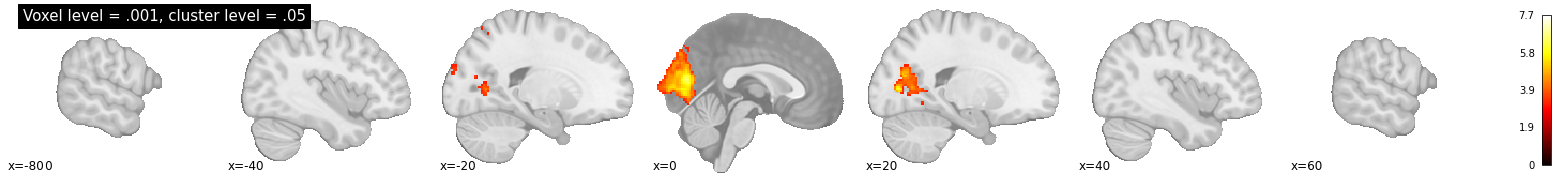

In [122]:
human_dog_thresholded_map = AON_second_level_dir / "human-dog_z_map_threshold.nii.gz"

plotting.plot_stat_map(human_dog_thresholded_map, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Voxel level = .001, cluster level = .05", bg_img = template, black_bg=False)

In [124]:
# get info on anatomical regions of cluster peaks
cluster_info, peak_info = get_statmap_info(human_dog_thresholded_map,
                                           cluster_extent = 1)
peak_info.head(5)

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,-8.0,-98.0,12.0,7.704216,40376.0,Occipital_Sup_L,ctx-lh-cuneus,63.0% Left_Occipital_Pole
1,2.0,-6.0,-80.0,52.0,4.154133,744.0,Precuneus_L,Unknown,25.0% Left_Precuneous_Cortex; 22.0% Left_Later...
2,3.0,-18.0,-70.0,60.0,4.590106,568.0,Parietal_Sup_L,Left-Cerebral-White-Matter,58.0% Left_Lateral_Occipital_Cortex_superior_d...
3,4.0,16.0,-44.0,-6.0,3.645900,96.0,Lingual_R,ctx-rh-lingual,70.0% Right_Lingual_Gyrus; 9.0% Right_Cingulat...
4,5.0,36.0,-50.0,-2.0,4.329507,88.0,no_label,Right-Cerebral-White-Matter,0% no_label


### 7. Dog > Human

In [125]:
# define paths
dog_human_image_path = f"{AON_second_level_dir}/dog-human_z_map.nii.gz"
dog_human_brain_mask_path = f"{masks_templates_dir}/dog-human_mask.nii.gz"

# use the function
MySecondLevelTTest(subject_list, cmaps_dog_human, dog_human_image_path, dog_human_brain_mask_path)

Creating design matrix
Fitting second level model


Fitting second level model. Take a deep breath
Computation of second level model done in 0 seconds


Computing contrast
Creating default mask based on cmaps
Storing the z-contrast map in directory: /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/second_level/AON-task/dog-human_z_map.nii.gz and default brain mask in /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/masks_templates/dog-human_mask.nii.gz
Done


In [127]:
# use the mask to run FSL smoothest
dog_human_smooth = fsl.SmoothEstimate(mask_file=dog_human_brain_mask_path, zstat_file=dog_human_image_path)
dog_human_smooth.run()

230422-12:54:10,60 nipype.interface INFO:
	 stdout 2023-04-22T12:54:10.060756:DLH 0.0212655
230422-12:54:10,63 nipype.interface INFO:
	 stdout 2023-04-22T12:54:10.060756:VOLUME 239547
230422-12:54:10,64 nipype.interface INFO:
	 stdout 2023-04-22T12:54:10.060756:RESELS 217.096


Use the inputs from fsl.SmoothEstimate for our GRF correction

In [128]:
# create fsl cluster object with the inputs from above
dog_human_cluster = fsl.Cluster(in_file = dog_human_image_path,
                            dlh = 0.0212655,
                            volume = 239547,
                            threshold = 3.1, # uncorrected threshold in z-scale of alpha = .001
                            pthreshold = 0.05, # cluster level threshold of alpha = .05
                            out_threshold_file =True,
                            out_index_file = True,
                            out_localmax_txt_file = True,
                            minclustersize = True)

In [129]:
# change the working directory to the directory in which I want to have my output
os.chdir(AON_second_level_dir)
# run fsl cluster to create the thresholded map
dog_human_cluster.run()

230422-12:54:35,28 nipype.interface INFO:
	 stdout 2023-04-22T12:54:35.028425:Minimum cluster size under p-threshold = 226
230422-12:54:35,30 nipype.interface INFO:
	 stdout 2023-04-22T12:54:35.030841:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
230422-12:54:35,31 nipype.interface INFO:
	 stdout 2023-04-22T12:54:35.030841:4	15361	3.07e-37	36.5	9.41	22	24	37	42.1	23	34.7
230422-12:54:35,32 nipype.interface INFO:
	 stdout 2023-04-22T12:54:35.030841:3	5292	3.5e-18	17.5	6.09	31	42	73	22.9	47.5	60.6
230422-12:54:35,33 nipype.interface INFO:
	 stdout 2023-04-22T12:54:35.030841:2	5011	1.59e-17	16.8	7.39	75	52	58	67.2	47.3	60.7
230422-12:54:35,34 nipype.interface INFO:
	 stdout 2023-04-22T12:54:35.030841:1	552	0.000755	3.12	6.3	73	68	57	73	66.2	53


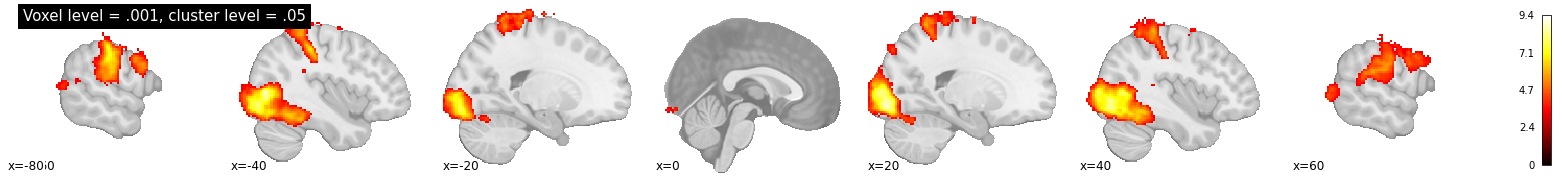

In [130]:
dog_human_thresholded_map = AON_second_level_dir / "dog-human_z_map_threshold.nii.gz"

plotting.plot_stat_map(dog_human_thresholded_map, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Voxel level = .001, cluster level = .05", bg_img = template, black_bg=False)

In [131]:
# get info on anatomical regions of cluster peaks
cluster_info, peak_info = get_statmap_info(dog_human_thresholded_map,
                                           cluster_extent = 1)
peak_info.head(5)

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,46.0,-78.0,2.0,9.408066,122256.0,Occipital_Mid_R,ctx-rh-lateraloccipital,61.0% Right_Lateral_Occipital_Cortex_inferior_...
1,2.0,28.0,-42.0,74.0,6.091875,40904.0,Postcentral_R,Unknown,19.0% Right_Superior_Parietal_Lobule; 8.0% Rig...
2,3.0,-60.0,-22.0,44.0,7.392216,38944.0,Parietal_Inf_L,Unknown,59.0% Left_Postcentral_Gyrus; 12.0% Left_Supra...
3,4.0,-56.0,10.0,42.0,6.297931,4416.0,Precentral_L,Unknown,9.0% Left_Middle_Frontal_Gyrus
4,5.0,-28.0,-10.0,58.0,4.836740,912.0,Precentral_L,Unknown,45.0% Left_Precentral_Gyrus; 13.0% Left_Superi...


## Action Second Level Model

**Load the contrast maps**

In [41]:
## Action contrasts

## contrasts to baseline

# all action - baseline
cmaps_action = sorted(
    glob(f"{action_first_level_dir}/action-baseline/*.nii.gz",
         recursive=True)
)

# hand - baseline
cmaps_hand = sorted(
    glob(f"{action_first_level_dir}/hand-baseline/*.nii.gz",
         recursive=True)
)

# mouth - baseline
cmaps_mouth = sorted(
    glob(f"{action_first_level_dir}/mouth-baseline/*.nii.gz",
         recursive=True)
)

## comparisons

# hand vs. mouth
cmaps_hand_mouth = sorted(
    glob(f"{action_first_level_dir}/hand-mouth/*.nii.gz",
         recursive=True)
)

# mouth vs. hand
cmaps_mouth_hand = sorted(
    glob(f"{action_first_level_dir}/mouth-hand/*.nii.gz",
         recursive=True)
)

**We do one-sample t-tests again, so we can re-use the function from above**


In [42]:
# define paths
action_avg_image_path = f"{action_second_level_dir}/action-baseline_z_map.nii.gz"
action_brain_mask_path = f"{masks_templates_dir}/action_brain_mask.nii.gz"

# use the function
MySecondLevelTTest(subject_list, cmaps_action, action_avg_image_path, action_brain_mask_path)

Creating design matrix
Fitting second level model


Fitting second level model. Take a deep breath
Computation of second level model done in 0 seconds


Computing contrast
Creating default mask based on cmaps
Storing the z-contrast map in directory: /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/second_level/action-task/action-baseline_z_map.nii.gz and default brain mask in /home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION/derivatives/masks_templates/action_brain_mask.nii.gz
Done


In [49]:
# use the mask to run FSL smoothest
action_smooth = fsl.SmoothEstimate(mask_file=f"{masks_templates_dir}/action_brain_mask.nii.gz", zstat_file=f"{action_second_level_dir}/action-baseline_z_map.nii.gz")
action_smooth_dict = action_smooth.run()

230417-18:58:26,412 nipype.interface INFO:
	 stdout 2023-04-17T18:58:26.412616:DLH 0.00960947
230417-18:58:26,414 nipype.interface INFO:
	 stdout 2023-04-17T18:58:26.412616:VOLUME 241156
230417-18:58:26,415 nipype.interface INFO:
	 stdout 2023-04-17T18:58:26.412616:RESELS 480.429


In [50]:
# create fsl cluster object with the inputs from above
action_cluster = fsl.Cluster(in_file = action_avg_image_path,
                          dlh = 0.00960947,
                          volume = 241156,
                          threshold = 3.1, # uncorrected threshold in z-scale of alpha = .001
                          pthreshold = 0.05, # cluster level threshold of alpha = .05
                          out_threshold_file =True,
                          out_index_file = True,
                          out_localmax_txt_file = True,
                          minclustersize = True)

In [51]:
# change the working directory to the directory in which I want to have my output
os.chdir(action_second_level_dir)

# run fsl cluster to create the thresholded map
action_cluster.run()

230417-18:58:33,199 nipype.interface INFO:
	 stdout 2023-04-17T18:58:33.199320:Minimum cluster size under p-threshold = 391
230417-18:58:33,201 nipype.interface INFO:
	 stdout 2023-04-17T18:58:33.201630:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
230417-18:58:33,202 nipype.interface INFO:
	 stdout 2023-04-17T18:58:33.201630:2	46686	0	45.7	10.8	67	54	65	54.8	45.6	44.7
230417-18:58:33,203 nipype.interface INFO:
	 stdout 2023-04-17T18:58:33.201630:1	14521	2.3e-21	20.6	9.47	16	62	56	20.7	57.7	45.8


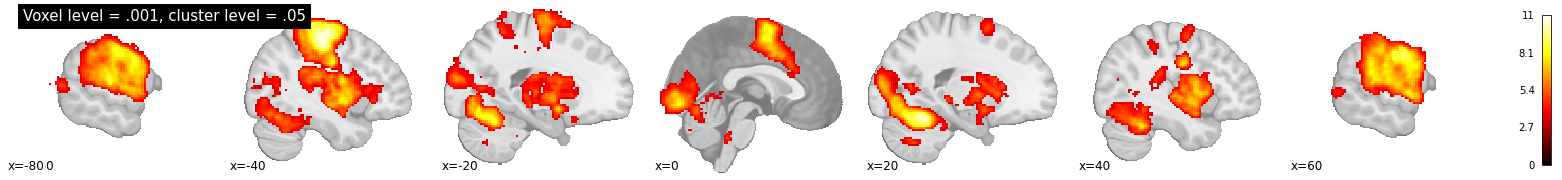

In [52]:
action_thresholded_map = action_second_level_dir / "action-baseline_z_map_threshold.nii.gz"

plotting.plot_stat_map(action_thresholded_map, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Voxel level = .001, cluster level = .05", bg_img = template, black_bg=False)

In [53]:
# get info on anatomical regions of cluster peaks
cluster_info, peak_info = get_statmap_info(action_thresholded_map,
                                           cluster_extent = 0)
cluster_info.head()

,cluster_id,peak_x,peak_y,peak_z,cluster_mean,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,-44.0,-18.0,58.0,5.218889,373056.0,17.00% no_label; 7.57% Postcentral_L; 5.85% Pr...,26.96% Unknown; 20.40% Left-Cerebral-White-Mat...,9.99% no_label; 9.23% Left_Precentral_Gyrus; 8...
1,2.0,58.0,-2.0,40.0,5.149233,116160.0,20.34% no_label; 12.09% Temporal_Sup_R; 10.96%...,31.89% Unknown; 25.88% Right-Cerebral-White-Ma...,15.00% Right_Precentral_Gyrus; 9.37% Right_Pos...
2,3.0,-20.0,14.0,-22.0,3.497942,200.0,88.00% OFCpost_L; 12.00% OFCmed_L,92.00% ctx-lh-lateralorbitofrontal,100.00% Left_Frontal_Orbital_Cortex
3,4.0,-2.0,-44.0,4.0,3.233980,40.0,60.00% no_label; 40.00% Vermis_4_5,100.00% Unknown,80.00% Left_Cingulate_Gyrus_posterior_division...
4,5.0,-18.0,-38.0,-38.0,3.507352,24.0,100.00% no_label,100.00% Left-Cerebellum-White-Matter,66.67% Brain-Stem; 33.33% no_label


## Conjunction Analysis

**Binarize the corrected all action observation > baseline image**

In [54]:
aon_masker = nl.image.binarize_img(aon_thresholded_map, mask_img=None)

/usr/local/lib/python3.8/dist-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


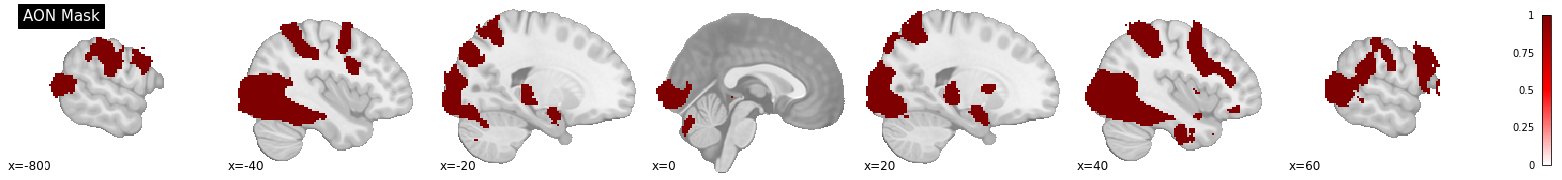

In [55]:
plotting.plot_stat_map(aon_masker, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="AON Mask", bg_img = template, cmap="seismic", black_bg = False)

In [56]:
# save the mask to path
aon_mask_path = f"{masks_templates_dir}/AON_mask.nii.gz"
aon_masker.to_filename(aon_mask_path)

**Binarize the corrected all action > baseline image**

In [57]:
action_masker = nl.image.binarize_img(action_thresholded_map, threshold=0, mask_img=None)

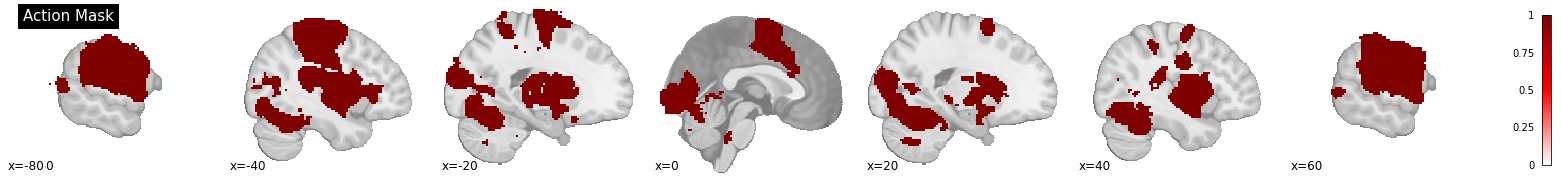

In [58]:
plotting.plot_stat_map(action_masker, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Action Mask", bg_img = template, cmap="seismic", black_bg = False)

In [59]:
# save the mask to path
action_mask_path = f"{masks_templates_dir}/action_mask.nii.gz"
action_masker.to_filename(action_mask_path)

#### Conjunction of the Masks from the Action Observation and the Action Contrasts

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


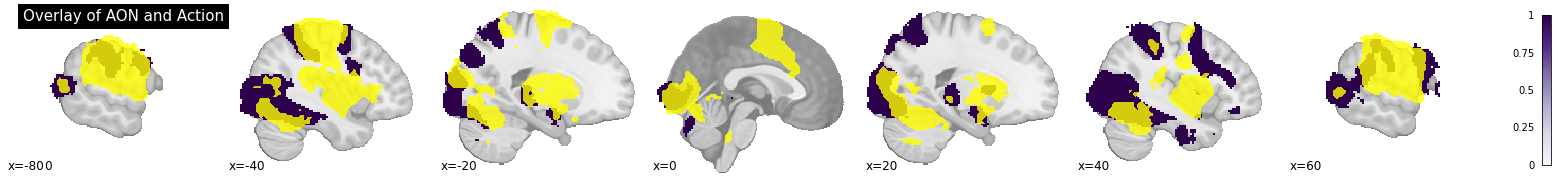

In [60]:
# Visually overlay the action map on top of the action map
aon_plot = plotting.plot_stat_map(aon_masker, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Overlay of AON and Action", bg_img = template, cmap="PuOr", black_bg = False)
aon_plot.add_contours(action_masker, filled=True, alpha=0.8, colors="yellow")

In [61]:
conjunction = math_img("aon_img * action_img", aon_img=aon_masker, action_img=action_masker)

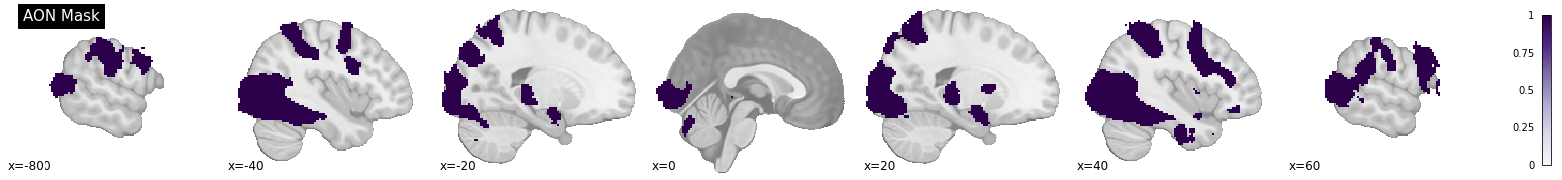

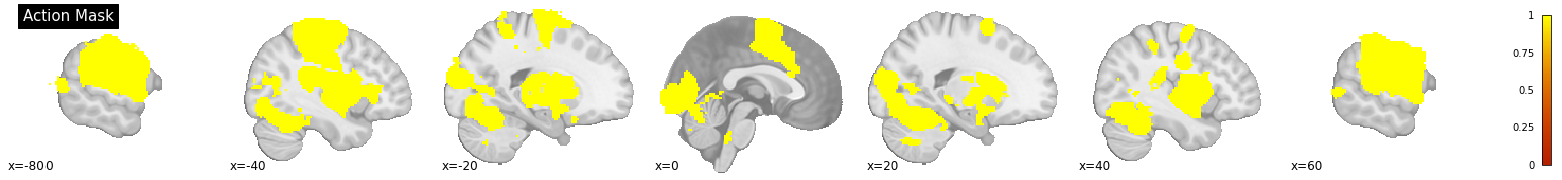

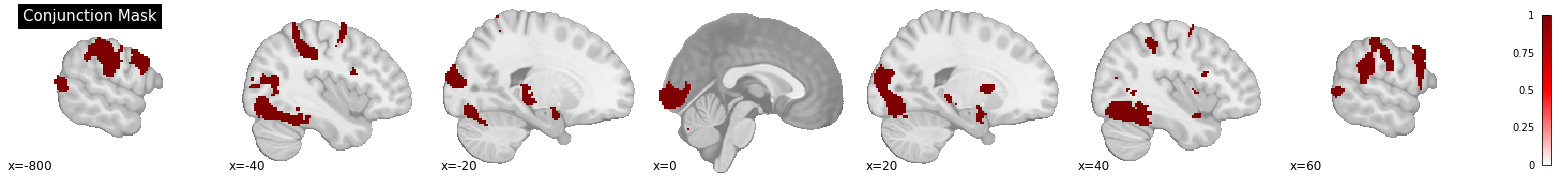

In [62]:
# plot the two individual and the conjunction mask
plotting.plot_stat_map(aon_masker, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="AON Mask", bg_img = template, cmap="PuOr", black_bg = False)

plotting.plot_stat_map(action_masker, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Action Mask", bg_img = template, cmap="gnuplot", black_bg = False)

plotting.plot_stat_map(conjunction, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Conjunction Mask", bg_img = template, cmap="seismic", black_bg = False)

In [63]:
# save the conjunction mask to path 
conjunction_mask_path = f"{masks_templates_dir}/conjunction_mask.nii.gz"
conjunction.to_filename(conjunction_mask_path)